In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

file_path = "/content/CN1_M1.txt"
with open(file_path, "r", encoding="utf-8") as f:
    qp_text = f.read()

# Define regex pattern to extract required fields
# Only match question numbers like 1a, 2b, 3c (exclude things like 24E)
pattern = re.compile(
    r"(?P<QNo>[1-9][a-z])\s*[\n:]?"                  # Match 1a, 2b... but not 24E
    r"(?P<Question>.*?)\s+"
    r"(?P<Marks>\d+)\s+"
    r"(?P<CO>\d+)\s+"
    r"(?P<BloomLevel>L\d+)\s+"
    r"(?P<PO>\d+)\s+"
    r"(?P<PICode>\d+\.\d+\.\d+)",
    re.DOTALL
)

# Apply regex and create a DataFrame
matches = pattern.findall(qp_text)

# Convert to DataFrame
qp_metadata = pd.DataFrame(matches, columns=["Q.No", "Question", "Max Marks", "CO", "Bloom Level", "PO", "PI Code"])

# Print the extracted data
print("=== Extracted Question Metadata ===")
print(qp_metadata.to_string(index=False))


=== Extracted Question Metadata ===
Q.No                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [2]:
# === Save the extracted metadata to CSV ===
output_csv_path = "/content/CN1_Question_Metadata_CLEAN.csv"
qp_metadata.to_csv(output_csv_path, index=False)

# === Confirm success and preview ===
print(f"\n✅ Metadata successfully saved to: {output_csv_path}")
print("\n📄 Preview of Saved Data:")
print(qp_metadata.head())



✅ Metadata successfully saved to: /content/CN1_Question_Metadata_CLEAN.csv

📄 Preview of Saved Data:
  Q.No                                           Question Max Marks CO  \
0   1a  Explain with diagram OSI model architecture. L...         6  1   
1   1b  Illustrate with diagram DDoS attack. Justify w...         6  1   
2   1c  i.\tDiscuss the header format of HTTP request ...         8  2   
3   2a  Consider an e-commerce site that wants to keep...         6  2   
4   2b  Suppose Anil with a Web-based e-mail account s...         6  2   

  Bloom Level PO PI Code  
0          L2  1   1.4.5  
1          L3  1   1.4.5  
2          L3  1   1.4.5  
3          L2  1   1.4.5  
4          L3  1   1.4.5  


In [3]:
#Extract question labels from metadata
question_labels = qp_metadata["Q.No"].tolist()

#Extract metadata as series with question label as index
max_marks = pd.Series(qp_metadata["Max Marks"].astype(int).values, index=question_labels)
pi_series = pd.Series(qp_metadata["PI Code"].values, index=question_labels)
blooms_series = pd.Series(qp_metadata["Bloom Level"].values, index=question_labels)
co_series = pd.Series(qp_metadata["CO"].astype(int).values, index=question_labels)


In [4]:
# Step 1: Get valid question labels from marks_df

# Load student marks CSV
df = pd.read_csv("/content/C_M1.csv")  # Or update with the correct name
marks_df = df.iloc[:, 1:].replace("-", np.nan).apply(pd.to_numeric, errors="coerce")


valid_questions = list(marks_df.columns)

# Step 2: Filter qp_metadata to keep only valid Q.No
qp_metadata_cleaned = qp_metadata[qp_metadata["Q.No"].isin(valid_questions)]

# Step 3: Update question_labels
question_labels = qp_metadata_cleaned["Q.No"].tolist()

# Step 4: Filter marks_df
marks_df_filtered = marks_df[question_labels]

# Step 5: Build summary using cleaned metadata
summary = pd.DataFrame(index=question_labels)
summary['PI'] = qp_metadata_cleaned.set_index("Q.No")["PI Code"]
summary['Bloom'] = qp_metadata_cleaned.set_index("Q.No")["Bloom Level"]
summary['CO'] = qp_metadata_cleaned.set_index("Q.No")["CO"].astype(int)
summary['Max Marks'] = qp_metadata_cleaned.set_index("Q.No")["Max Marks"].astype(int)

# Step 6: Metrics
summary['Avg Marks'] = marks_df_filtered.mean()
summary['Attempted %'] = (marks_df_filtered.count() / len(marks_df_filtered)) * 100
summary['Attainment %'] = (summary['Avg Marks'] / summary['Max Marks']) * 100
summary['Actual Attainment'] = (marks_df_filtered.sum() / (len(marks_df_filtered) * summary['Max Marks'])) * 100

# Step 7: Performance classification
def classify(att):
    if att >= 75:
        return 'Fine'
    elif 60 <= att < 75:
        return 'OK'
    else:
        return 'Concern'

summary['Performance'] = summary['Attainment %'].apply(classify)


In [5]:
print("Question Labels from Metadata:", qp_metadata["Q.No"].tolist())
print("Question Labels in Student CSV:", marks_df.columns.tolist())


Question Labels from Metadata: ['1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c']
Question Labels in Student CSV: ['Roll.No', 'USN', 'Name', '1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26']


In [7]:
# === Step 4: High vs Low Scorer Analysis ===
high_scores = {}
low_scores = {}
hs_ls_diff = {}

question_labels = summary.index.tolist()
marks_df_filtered = marks_df[question_labels]

for q in question_labels:
    max_mark = summary.loc[q, 'Max Marks']
    q_scores = marks_df_filtered[q].dropna()  # Drop NaN values for accurate min/max

    # Highest score (HS) as a percentage of max marks
    hs = q_scores.max() if not q_scores.empty else 0
    hs_pct = (hs / max_mark) * 100 if max_mark > 0 else 0

    # Lowest non-zero score (LS) as a percentage of max marks
    non_zero_scores = q_scores[q_scores > 0]  # Exclude zeros
    ls = non_zero_scores.min() if not non_zero_scores.empty else 0
    ls_pct = (ls / max_mark) * 100 if max_mark > 0 else 0

    # Difference (HS % - LS %)
    diff = hs_pct - ls_pct

    high_scores[q] = round(hs_pct, 1)
    low_scores[q] = round(ls_pct, 1)
    hs_ls_diff[q] = round(diff, 1)

hs_ls_table = pd.DataFrame({
    "% HS": high_scores,
    "% LS": low_scores,
    "%Difference (HS - LS)": hs_ls_diff
}).round(1)


# === Step 9: Display Summary Tables with Rounded Values ===
summary_rounded = summary.copy()
for col in summary_rounded.select_dtypes(include='number').columns:
    summary_rounded[col] = summary_rounded[col].round(2)

try:
    from tabulate import tabulate

    print("\n=== Summary Table ===")
    print(tabulate(summary_rounded.reset_index(), headers='keys', tablefmt='pretty', showindex=False))

    print("\n=== High vs Low Scorer Table ===")
    print(tabulate(hs_ls_table.reset_index(), headers='keys', tablefmt='pretty', showindex=False))

except ImportError:
    print("\n=== Summary Table ===")
    print(summary_rounded.to_string(index=True, justify='center'))

    print("\n=== High vs Low Scorer Table ===")
    print(hs_ls_table.to_string(index=True, justify='center'))

from collections import defaultdict

# === Step 10: Student Total Marks Table (Best 2 out of 3 Questions + Grades) ===
# Step 10.1: Dynamically group sub-questions using prefix
question_groups = defaultdict(list)
for q in summary.index:  # assumes summary.index has Q.No like 1a, 2b, etc.
    main_q = f"Q{q[0]}"  # extract numeric prefix (e.g., 1a -> Q1)
    question_groups[main_q].append(q)

# Optional: sort each sub-question list
for key in question_groups:
    question_groups[key] = sorted(question_groups[key])

# Convert to regular dict
question_groups = dict(question_groups)
print("Dynamic Question Groups:", question_groups)

# Step 10.2: Calculate combined scores for each main question group
combined_scores = pd.DataFrame(index=marks_df.index)
for q_main, subparts in question_groups.items():
    combined_scores[q_main] = marks_df[subparts].sum(axis=1, skipna=True)

# Step 10.3: Best 2 out of 3 (or more)
combined_scores["Total /40"] = combined_scores.apply(lambda row: sum(sorted(row, reverse=True)[:2]), axis=1)
combined_scores["Total /20"] = round((combined_scores["Total /40"] / 40) * 20, 2)

# Step 10.4: Add Roll No from original file
df = pd.read_csv("/content/C_M1.csv")
combined_scores.insert(0, "Roll No", df.iloc[:, 0])

# Step 10.5: Add Grade based on Total /20
def assign_grade(score):
    if score >= 17:
        return "S"
    elif score >= 12:
        return "A"
    elif score >= 8:
        return "B"
    elif score >= 5:
        return "C"
    else:
        return "D"

combined_scores["Grade"] = combined_scores["Total /20"].apply(assign_grade)

# Step 10.6: Display the final table
print("\n=== Student Total Marks Table (Best 2 Questions + Grades) ===")
if 'tabulate' in globals():
    print(tabulate(combined_scores.reset_index(drop=True), headers='keys', tablefmt='pretty', showindex=False))
else:
    print(combined_scores.reset_index(drop=True).to_string(index=False))


=== Summary Table ===
+-------+-------+-------+----+-----------+-----------+-------------+--------------+-------------------+-------------+
| index |  PI   | Bloom | CO | Max Marks | Avg Marks | Attempted % | Attainment % | Actual Attainment | Performance |
+-------+-------+-------+----+-----------+-----------+-------------+--------------+-------------------+-------------+
|  1a   | 1.4.5 |  L2   | 1  |     6     |   4.07    |    59.21    |    67.78     |       40.13       |     OK      |
|  1b   | 1.4.5 |  L3   | 1  |     6     |   4.05    |    56.58    |    67.44     |       38.16       |     OK      |
|  1c   | 1.4.5 |  L3   | 2  |     8     |   4.74    |    56.58    |     59.3     |       33.55       |   Concern   |
|  2a   | 1.4.5 |  L2   | 2  |     6     |   4.03    |    84.21    |    67.19     |       56.58       |     OK      |
|  2b   | 1.4.5 |  L3   | 2  |     6     |   3.97    |    76.32    |    66.09     |       50.44       |     OK      |
|  2c   | 2.2.3 |  L3   | 1  |   

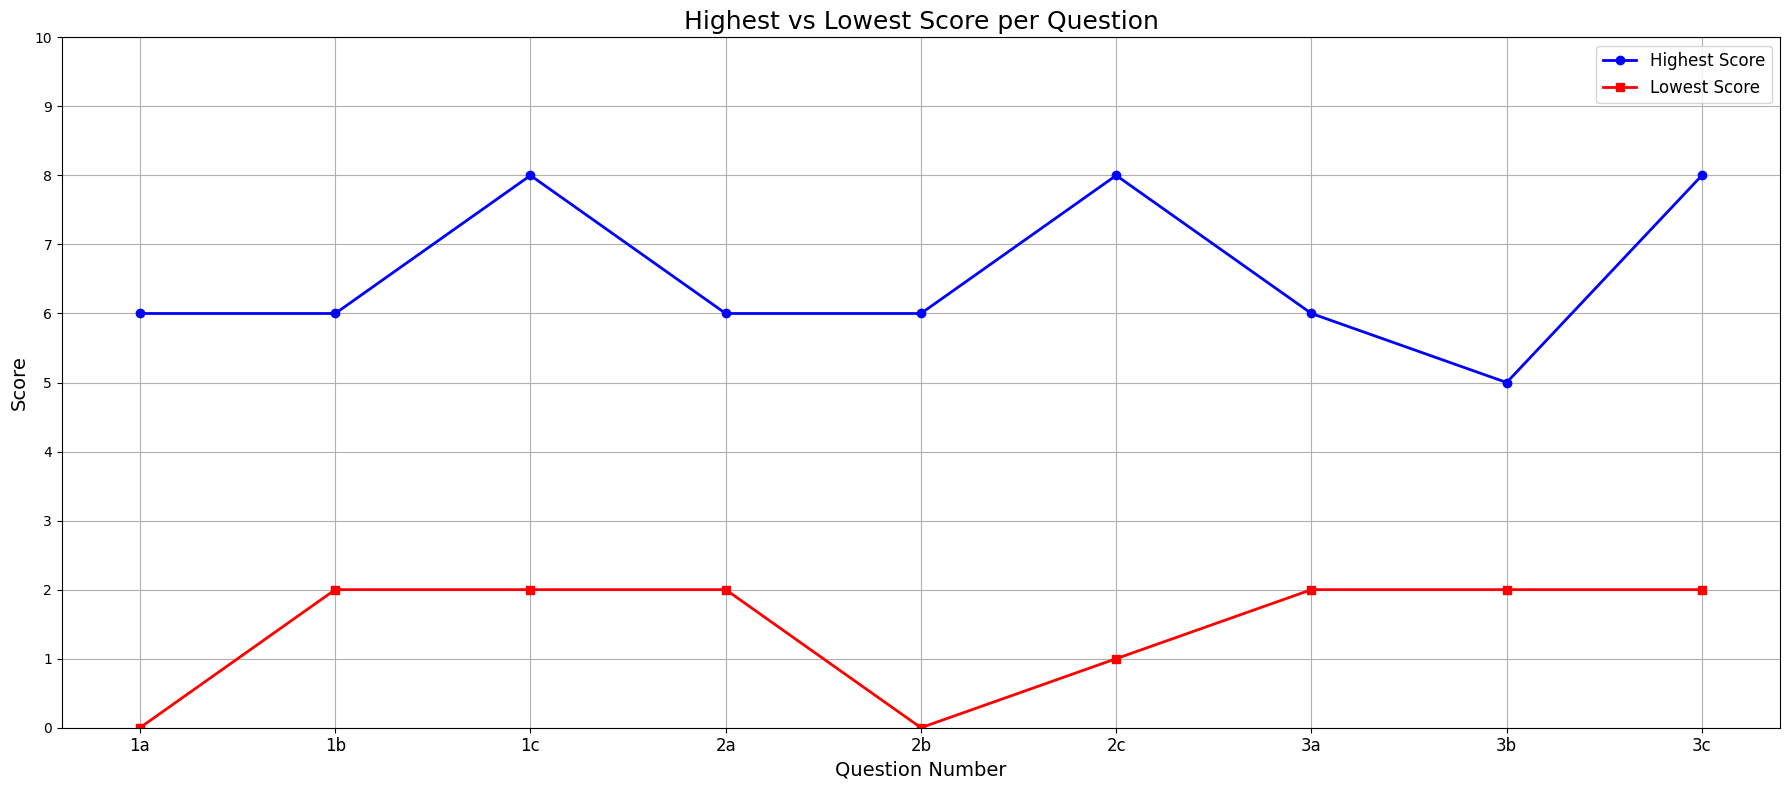

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load and clean
df = pd.read_csv("/content/C_M1.csv")
marks_df = df.copy()

# Step 2: Drop non-question columns
non_question_cols = ["SL.No","Roll.No", "USN", "Name"]
question_cols = [col for col in marks_df.columns if col not in non_question_cols]
marks_df = marks_df[question_cols]

# Step 3: Clean values
marks_df = marks_df.replace('-', pd.NA).apply(pd.to_numeric, errors='coerce')

# Step 4: Compute stats
high_scores = marks_df.max()
low_scores = marks_df.min()

# Step 5: Plot
plt.figure(figsize=(18, 8))
plt.plot(high_scores.index, high_scores.values, marker='o', label='Highest Score', color='blue', linewidth=2)
plt.plot(low_scores.index, low_scores.values, marker='s', label='Lowest Score', color='red', linewidth=2)

plt.title("Highest vs Lowest Score per Question", fontsize=18)
plt.xlabel("Question Number", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(range(0, 45, 1))
plt.ylim(0, 10)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**tinyllama-1.1b-chat**

In [12]:
# from transformers import AutoTokenizer, AutoModelForCausalLM
# import os

# # ✅ Set model ID and local path
# model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# local_dir = "/content/drive/MyDrive/NLP_MODELS/models/tinyllama-1.1b-chat"  # ✅ you can change this path if needed

# # ✅ Create the folder if it doesn't exist
# os.makedirs(local_dir, exist_ok=True)

# # ✅ Download and save tokenizer
# print("📥 Downloading tokenizer...")
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# tokenizer.save_pretrained(local_dir)

# # ✅ Download and save model weights
# print("📥 Downloading model weights (may take ~5 minutes)...")
# model = AutoModelForCausalLM.from_pretrained(model_id)
# model.save_pretrained(local_dir)

# print(f"✅ Model and tokenizer saved locally to: {local_dir}")


In [10]:
def parse_question_paper(qp_txt_path):
    with open(qp_txt_path, "r", encoding="utf-8") as f:
        text = f.read()

    pattern = re.compile(
        r"(?P<QNo>[1-9][a-z])\s*[\n:]?"
        r"(?P<Question>.*?)\s+"
        r"(?P<Marks>\d+)\s+"
        r"(?P<CO>\d+)\s+"
        r"(?P<BloomLevel>L\d+)\s+"
        r"(?P<PO>\d+)\s+"
        r"(?P<PICode>\d+\.\d+\.\d+)",
        re.DOTALL
    )

    matches = pattern.findall(text)
    df = pd.DataFrame(matches, columns=["Q.No", "Question", "Max Marks", "CO", "Bloom Level", "PO", "PI Code"])
    df["Q.No"] = df["Q.No"].str.lower()
    return df

#**Charts for each question **

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.drawing.image import Image as XLImage
import os
import re
import tempfile
import torch

# Direct assignments instead of function arguments
marks_csv_path = '/content/C_M1.csv'
qp_txt_path = '/content/CN1_M1.txt'

# Tokenizer and model initialization (adjust based on your setup)
tokenizer = None  # Your tokenizer here
model = None  # Your model here

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parse the question paper and load marks data
qp_metadata = parse_question_paper(qp_txt_path)
marks_df = pd.read_csv(marks_csv_path)

# Processing marks data
marks_only = marks_df.iloc[:, 1:].replace('-', pd.NA).apply(pd.to_numeric, errors='coerce')

# Filter question paper metadata based on available marks data
qp_metadata = qp_metadata[qp_metadata["Q.No"].isin(marks_only.columns)]
qp_metadata = qp_metadata.set_index("Q.No")

# Extract the relevant question labels and filter marks data accordingly
question_labels = qp_metadata.index.tolist()
marks_filtered = marks_only[question_labels]

# Create a summary DataFrame
summary = pd.DataFrame(index=question_labels)
summary["PI"] = qp_metadata["PI Code"]
summary["Bloom"] = qp_metadata["Bloom Level"]
summary["CO"] = qp_metadata["CO"].astype(int)
summary["Max Marks"] = qp_metadata["Max Marks"].astype(int)
summary["Avg Marks"] = marks_filtered.mean()
summary["Attempted %"] = (marks_filtered.count() / len(marks_filtered)) * 100
summary["Attainment %"] = (summary["Avg Marks"] / summary["Max Marks"]) * 100
summary["Actual Attainment"] = (marks_filtered.sum() / (len(marks_filtered) * summary["Max Marks"])) * 100
summary["Performance"] = summary["Attainment %"].apply(lambda x: "Fine" if x >= 75 else ("OK" if x >= 60 else "Concern"))

# Calculate High Scores (HS) and Low Scores (LS) for each question
hs_scores, ls_scores = {}, {}

for q in summary.index:
    max_m = summary.loc[q, "Max Marks"]
    scores = marks_filtered[q]

    # Filter out zero scores when calculating the lowest score
    non_zero_scores = scores[scores > 0]

    # Get the highest and lowest scores
    highest = scores.max(skipna=True)
    lowest = non_zero_scores.min(skipna=True) if not non_zero_scores.empty else float('nan')  # Avoid NaN if all scores are zero

    hs_scores[q] = (highest / max_m) * 100
    ls_scores[q] = (lowest / max_m) * 100 if pd.notna(lowest) else 0  # Handle NaN

# Create HS-LS summary table
hs_ls_table = pd.DataFrame({
    "% HS": hs_scores,
    "% LS": ls_scores
})
hs_ls_table["%Difference (HS - LS)"] = hs_ls_table["% HS"] - hs_ls_table["% LS"]

# Update summary with HS/LS scores
summary["% High Score"] = hs_ls_table["% HS"]
summary["% Low Score"] = hs_ls_table["% LS"]
summary["% HS - LS Diff"] = hs_ls_table["%Difference (HS - LS)"]


# Group questions and calculate combined scores
question_groups = defaultdict(list)
for q in summary.index:
    question_groups[f"Q{q[0]}"] += [q]

combined_scores = pd.DataFrame(index=marks_only.index)
for group, subparts in question_groups.items():
    combined_scores[group] = marks_only[subparts].sum(axis=1, skipna=True)

total_raw = combined_scores.sum(axis=1)
max_total = sum(summary.loc[q, "Max Marks"] for q in summary.index)
combined_scores["Total"] = total_raw
combined_scores["Total /20"] = (total_raw / 2).round(2)

# Function to assign grades
def grade(x):
    if x >= 18: return "S"
    elif x >= 16: return "A"
    elif x >= 14: return "B"
    elif x >= 12: return "C"
    else: return "D"

# Assign grades based on the calculated score
combined_scores["Grade"] = combined_scores["Total /20"].apply(grade)
combined_scores.insert(0, "Roll No", marks_df.iloc[:, 0])

# At this point, you can display or save the results (e.g., summary, combined_scores)
combined_scores.head()  # Show the top of the combined scores table


,Roll No,Q1,Q2,Q3,Total,Total /20,Grade
0,1.0,6.0,12.0,0.0,18.0,9.0,D
1,2.0,12.0,9.0,0.0,21.0,10.5,D
2,3.0,0.0,0.0,0.0,0.0,0.0,D
3,4.0,12.0,4.0,0.0,16.0,8.0,D
4,5.0,0.0,0.0,10.0,10.0,5.0,D


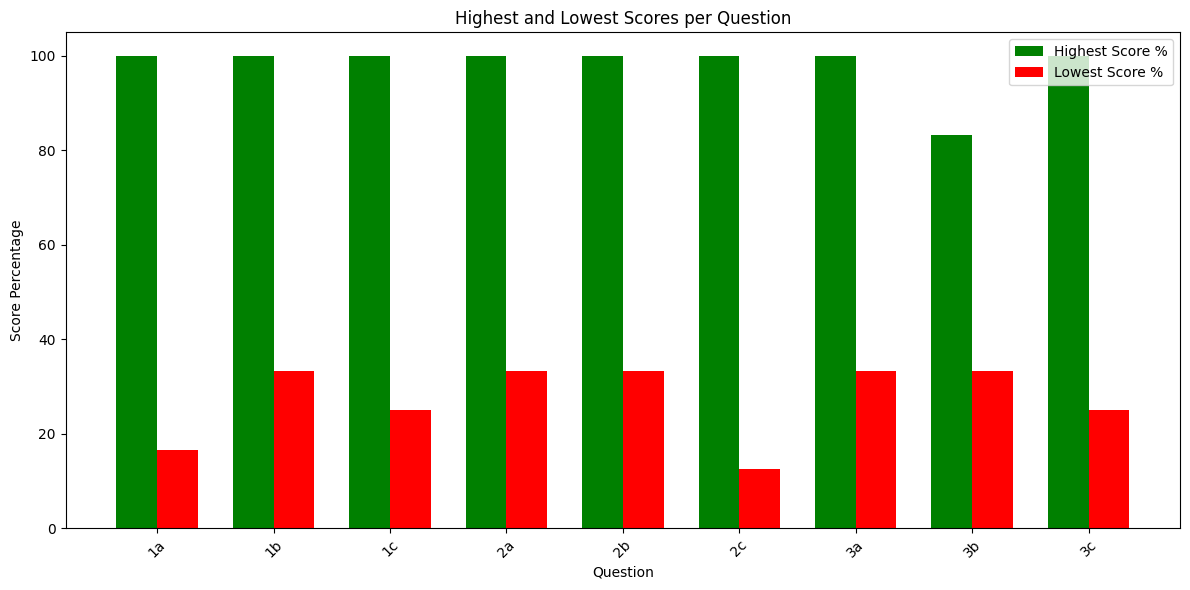

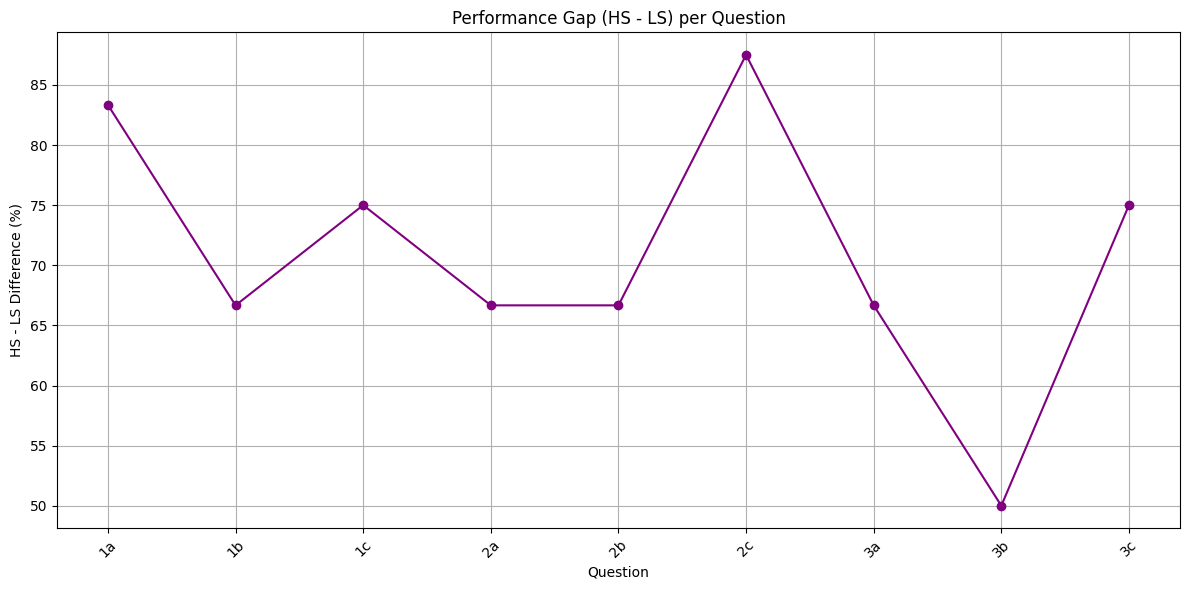

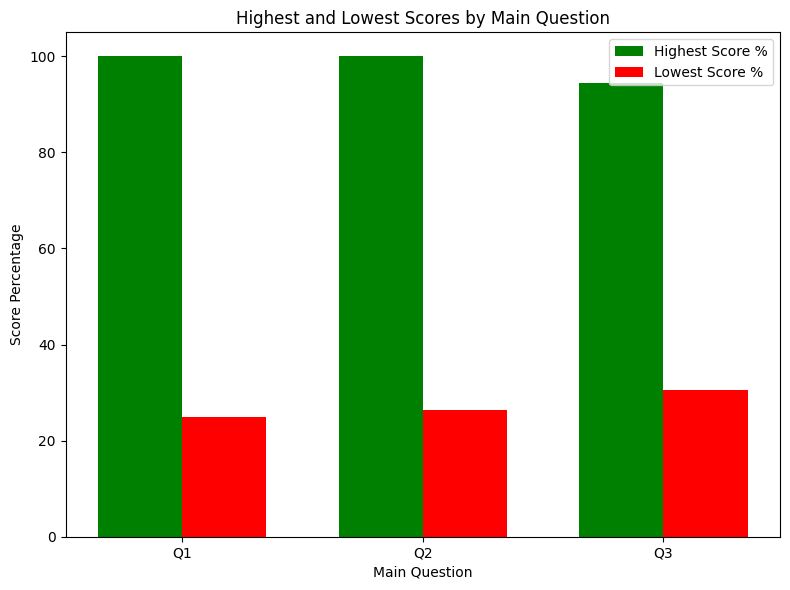

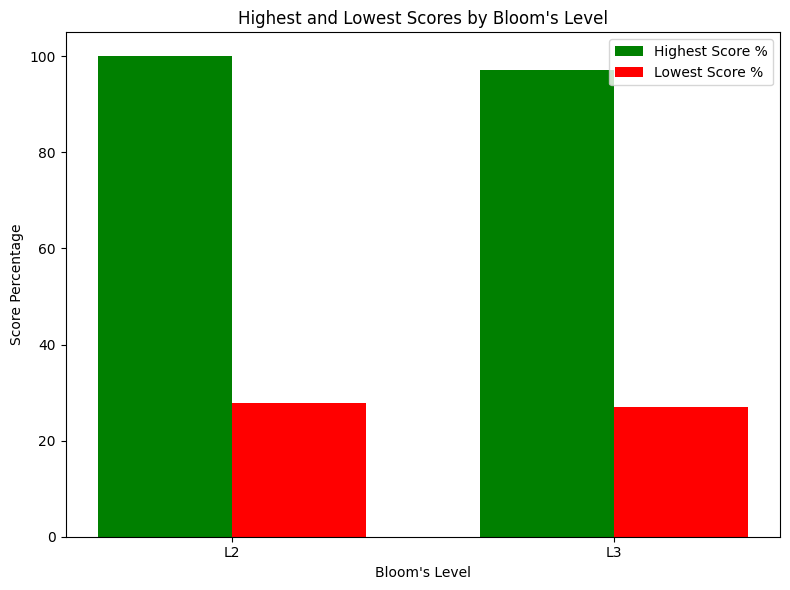

CSV files saved: 'question_summary.csv', 'hs_ls_summary.csv', 'grouped_hs_ls_summary.csv', 'student_scores.csv'
Plots saved: 'hs_ls_bar_plot.png', 'hs_ls_attainment_bar_plot.png', 'hs_ls_diff_line_plot.png', 'hs_ls_main_question_bar_plot.png', 'hs_ls_bloom_bar_plot.png', 'score_distribution_box_plot.png'


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure plots are displayed inline (for Jupyter/Colab)
%matplotlib inline

# 1. Bar Plot for HS and LS per Question
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(hs_ls_table.index))
plt.bar(index, hs_ls_table['% HS'], bar_width, label='Highest Score %', color='green')
plt.bar([i + bar_width for i in index], hs_ls_table['% LS'], bar_width, label='Lowest Score %', color='red')
plt.xlabel('Question')
plt.ylabel('Score Percentage')
plt.title('Highest and Lowest Scores per Question')
plt.xticks([i + bar_width/2 for i in index], hs_ls_table.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('hs_ls_bar_plot.png')
plt.show()



# 3. Line Plot for HS - LS Difference
plt.figure(figsize=(12, 6))
plt.plot(hs_ls_table.index, hs_ls_table['%Difference (HS - LS)'], marker='o', color='purple')
plt.xlabel('Question')
plt.ylabel('HS - LS Difference (%)')
plt.title('Performance Gap (HS - LS) per Question')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('hs_ls_diff_line_plot.png')
plt.show()

# 4. Bar Plot Grouped by Main Question (Q1, Q2, Q3)
grouped_hs_ls = pd.DataFrame(index=['Q1', 'Q2', 'Q3'])
for group in ['Q1', 'Q2', 'Q3']:
    sub_questions = [q for q in hs_ls_table.index if q.startswith(group[1])]
    grouped_hs_ls.loc[group, '% HS'] = hs_ls_table.loc[sub_questions, '% HS'].mean()
    grouped_hs_ls.loc[group, '% LS'] = hs_ls_table.loc[sub_questions, '% LS'].mean()

plt.figure(figsize=(8, 6))
bar_width = 0.35
index = range(len(grouped_hs_ls.index))
plt.bar(index, grouped_hs_ls['% HS'], bar_width, label='Highest Score %', color='green')
plt.bar([i + bar_width for i in index], grouped_hs_ls['% LS'], bar_width, label='Lowest Score %', color='red')
plt.xlabel('Main Question')
plt.ylabel('Score Percentage')
plt.title('Highest and Lowest Scores by Main Question')
plt.xticks([i + bar_width/2 for i in index], grouped_hs_ls.index)
plt.legend()
plt.tight_layout()
plt.savefig('hs_ls_main_question_bar_plot.png')
plt.show()

# 5. Bar Plot by Bloom's Level
bloom_hs_ls = summary.groupby('Bloom')[['% High Score', '% Low Score']].mean()
plt.figure(figsize=(8, 6))
bar_width = 0.35
index = range(len(bloom_hs_ls.index))
plt.bar(index, bloom_hs_ls['% High Score'], bar_width, label='Highest Score %', color='green')
plt.bar([i + bar_width for i in index], bloom_hs_ls['% Low Score'], bar_width, label='Lowest Score %', color='red')
plt.xlabel('Bloom\'s Level')
plt.ylabel('Score Percentage')
plt.title('Highest and Lowest Scores by Bloom\'s Level')
plt.xticks([i + bar_width/2 for i in index], bloom_hs_ls.index)
plt.legend()
plt.tight_layout()
plt.savefig('hs_ls_bloom_bar_plot.png')
plt.show()



# Save updated CSVs with HS and LS focus
summary.to_csv('question_summary.csv', index=True)
hs_ls_table.to_csv('hs_ls_summary.csv', index=True)
grouped_hs_ls.to_csv('grouped_hs_ls_summary.csv', index=True)
combined_scores.to_csv('student_scores.csv', index=False)

print("CSV files saved: 'question_summary.csv', 'hs_ls_summary.csv', 'grouped_hs_ls_summary.csv', 'student_scores.csv'")
print("Plots saved: 'hs_ls_bar_plot.png', 'hs_ls_attainment_bar_plot.png', 'hs_ls_diff_line_plot.png', 'hs_ls_main_question_bar_plot.png', 'hs_ls_bloom_bar_plot.png', 'score_distribution_box_plot.png'")

#**VIOLON PLOT**

*   List item
*   List item



Question 1a (Blue Violin):
**Shape**: Moderately wide at 3-5 marks, tapering at the top (near 6 marks) and bottom (near 1 mark).
LS (Red Dot): Around 1 mark (consistent with 16.67% of 6 marks).
**Density**: Wider in the middle (3-5 marks), suggesting most scores clustered there, with fewer at the extremes.
**Insight**: The OSI model question had varied performance, with some students scoring low (1 mark) and others high (up to 6 marks, likely 100%). The spread indicates moderate difficulty.

Question 1b (Orange Violin):
**Shape**: Similar to 1a, wide at 3-5 marks, narrow at top and bottom.
LS (Red Dot): Around 2 marks (consistent with 33.33% of 6 marks).
**Density**: Balanced distribution, with a peak around 4-5 marks.
**Insight**: The DDoS mitigation question had better performance than 1a, with a higher LS (2 marks) and a denser middle, suggesting more students scored moderately to well.

Question 1c (Green Violin):
**Shape**: Wide at 4-6 marks, tapering at the bottom (near 1.5-2 marks).
LS (Red Dot): Around 1.5-2 marks (consistent with 25% of 8 marks).
**Density**: Strong concentration at higher marks (4-6), indicating good performance.
**Insight**: The HTTP methods question was relatively easy, with most students scoring above 4 marks and a low LS (1.5-2 marks) suggesting only a few struggled.

Question 2a (Red Violin):
Shape: Wide at 3-5 marks, narrow at top and bottom.
LS (Red Dot): Around 2-2.5 marks (consistent with 33.33% of 8 marks).
Density: Similar to 1b, with a peak around 4-5 marks.
Insight: The P2P networks question had moderate performance, with a higher LS (2-2.5 marks) and a dense middle, indicating consistent scoring.

Question 2b (Purple Violin):
Shape: Wide at 3-5 marks, narrow at top and bottom.
LS (Red Dot): Around 2-2.5 marks (consistent with 33.33% of 8 marks).
Density: Balanced, with a peak around 4 marks.
Insight: The P2P advantages question mirrored 2a, with similar LS and density, suggesting comparable difficulty.

Question 2c (Brown Violin):
Shape: Very narrow at the top (near 8 marks), extremely wide at the bottom (near 1 mark), with a tall, thin profile.
LS (Red Dot): Around 1 mark (consistent with 12.5% of 8 marks).
Density: Thick at the bottom (0-2 marks), indicating most students scored very low.
Insight: The network delays and throughput question was the most difficult, with a low LS (1 mark) and a dense cluster at the bottom, suggesting widespread struggle.

Question 3a (Pink Violin):
Shape: Wide at 3-5 marks, narrow at top and bottom.
LS (Red Dot): Around 2-2.5 marks (consistent with 33.33% of 6 marks).
Density: Peak around 4-5 marks, similar to 1b and 2a.
Insight: The circuit-switching question had moderate performance, with a higher LS and dense middle scores.

Question 3b (Gray Violin):
Shape: Narrower overall, with a peak around 3-4 marks and no width at 6 marks.
LS (Red Dot): Around 2 marks (consistent with 33.33% of 6 marks).
Density: Thinner and more concentrated, with no scores at the top (consistent with HS: 83.33% or 5 marks).
Insight: The DNS question was moderately difficult, with no perfect scores and a higher LS (2 marks), suggesting consistent but limited performance.

Question 3c (Yellow Violin):
Shape: Wide at 3-6 marks, tapering at the bottom (near 2 marks).
LS (Red Dot): Around 2 marks (consistent with 25% of 8 marks).
Density: Strong concentration at 4-6 marks, with a thin base.
Insight: The probability question had good performance overall, with a low LS (2 marks) and most scores in the higher range.

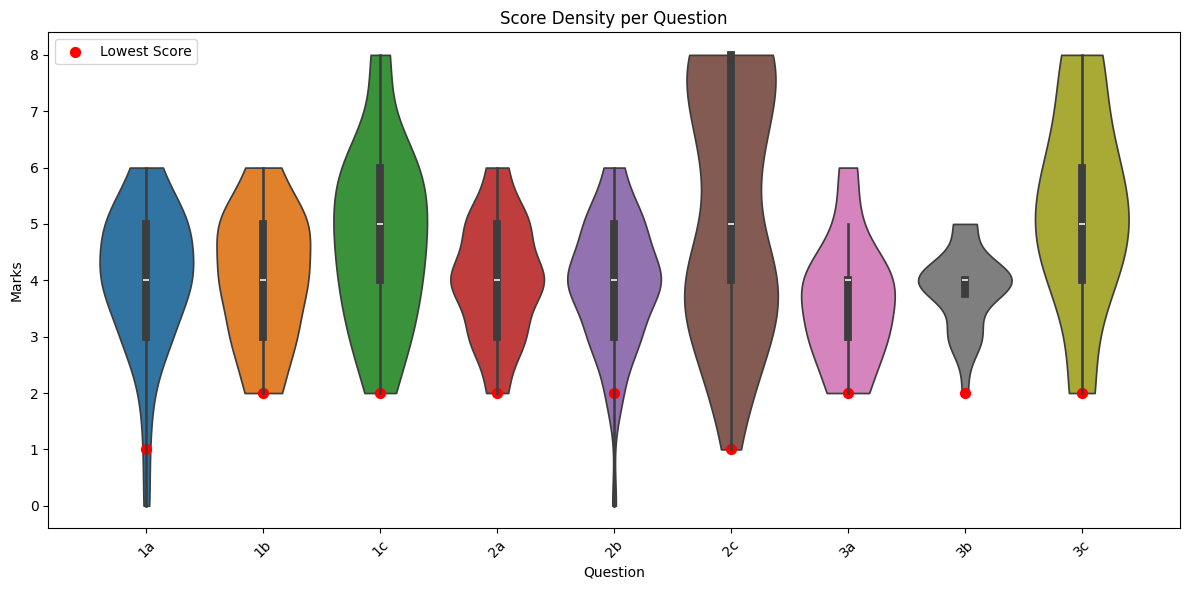

CSV files saved: 'question_summary.csv', 'hs_ls_summary.csv', 'grouped_metrics_summary.csv', 'student_scores.csv'
Plots saved: 'box_plot_ls.png', 'violin_plot.png', 'ls_attainment_bar_plot.png', 'performance_heatmap.png', 'radar_chart_main_questions.png', 'normalized_histogram_2c.png'


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure plots are displayed inline
%matplotlib inline



# 2. Violin Plot for Score Density
plt.figure(figsize=(12, 6))
sns.violinplot(data=marks_filtered, cut=0)
plt.xlabel('Question')
plt.ylabel('Marks')
plt.title('Score Density per Question')
for i, q in enumerate(marks_filtered.columns):
    ls = marks_filtered[q][marks_filtered[q] > 0].min() if (marks_filtered[q] > 0).any() else 0
    plt.scatter([i], [ls], color='red', s=50, label='Lowest Score' if i == 0 else "")
plt.legend()
plt.xticks(range(len(marks_filtered.columns)), marks_filtered.columns, rotation=45)
plt.tight_layout()
plt.savefig('violin_plot.png')
plt.show()



print("CSV files saved: 'question_summary.csv', 'hs_ls_summary.csv', 'grouped_metrics_summary.csv', 'student_scores.csv'")
print("Plots saved: 'box_plot_ls.png', 'violin_plot.png', 'ls_attainment_bar_plot.png', 'performance_heatmap.png', 'radar_chart_main_questions.png', 'normalized_histogram_2c.png'")

#**Detailed Analysis of Radar chart on HS-LS**
Highest Score (HS) Line (Green):
The green line is at 100% for most sub-questions (1a, 1b, 1c, 2a, 2b, 2c, 3a, 3c), suggesting that the highest score for these questions was the maximum possible (e.g., 100% of the total marks, such as 6 or 8 marks depending on the question).
The green line dips inward at 3b to approximately 80%-90% (likely around 83.33%, given the context of your earlier data where 3b’s max marks might be 6, with a highest score of 5), indicating that the highest score for 3b was less than the maximum.


Lowest Score (LS) Line (Red):
The red line varies across sub-questions, with values estimated from its position relative to the radial scale:
2c: Annotated as "LS: 34.2%", the lowest point on the chart, suggesting the lowest non-zero score was approximately 34.2% of the maximum marks (e.g., 2.74 out of 8 marks if max marks are 8).
1a, 3c: Appear around 40%-50%, indicating LS values in this range (e.g., 2.4-3 out of 6 marks).
1b, 2a, 2b, 3a, 3b: Appear to peak at around 50%-60%, suggesting LS values of 50% or higher (e.g., 3 out of 6 marks or 4 out of 8 marks).
1c: Appears around 40%-45%, indicating a moderate LS (e.g., 2.5-3 out of 6 marks).
The red line’s shape shows significant variation, with 2c as the lowest LS and several questions (1b, 2a, 2b, 3a, 3b) having the highest LS values.


HS-LS Gap:
The largest gap is at 2c, where HS is 100% and LS is 34.2%, a difference of approximately 65.8%. This indicates high variability—some students scored the maximum, while others scored as low as 34.2%.
The smallest gap appears at 3b, where HS is ~80%-90% (e.g., 83.33%) and LS is ~50%-60%, a difference of approximately 30%-33%. This suggests more consistent performance across students for 3b.
Other questions (e.g., 1a, 1c) have gaps of ~50%-60%, indicating moderate variability.
Shaded Areas:
The green shaded area is large, covering most of the chart due to HS being 100% for most questions, except at 3b.
The red shaded area is smaller and irregular, reflecting the varying LS values, with the deepest dip at 2c (34.2%) and peaks at 50%-60% for several questions.

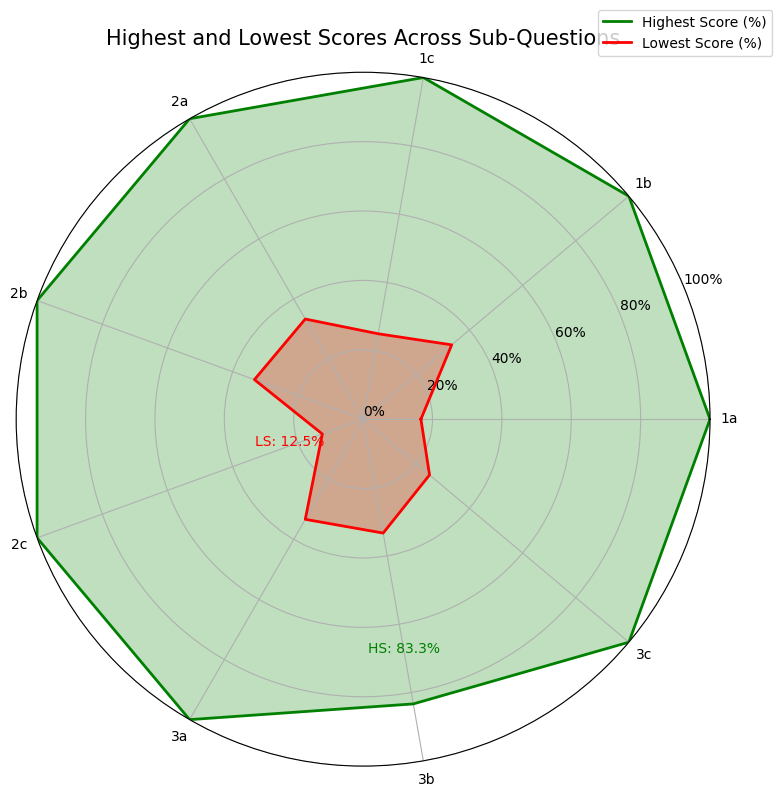

Radar chart saved as 'radar_chart_hs_ls.png'


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots are displayed inline (for Jupyter/Colab)
%matplotlib inline

# Extract data from hs_ls_table
labels = hs_ls_table.index.tolist()  # ['1a', '1b', '1c', '2a', '2b', '2c', '3a', '3b', '3c']
hs_values = hs_ls_table['% HS'].values.tolist()
ls_values = hs_ls_table['% LS'].values.tolist()

# Add the first value at the end to close the radar chart loop
hs_values += hs_values[:1]
ls_values += ls_values[:1]
labels += labels[:1]

# Compute the angles for each axis (sub-question)
num_vars = len(labels) - 1  # Use the original number of variables (9)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Add only once to close the loop, making it 10

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot HS and LS lines
ax.plot(angles, hs_values, linewidth=2, linestyle='solid', label='Highest Score (%)', color='green')
ax.fill(angles, hs_values, 'green', alpha=0.25)

ax.plot(angles, ls_values, linewidth=2, linestyle='solid', label='Lowest Score (%)', color='red')
ax.fill(angles, ls_values, 'red', alpha=0.25)

# Add labels for each axis (sub-question)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels[:-1])

# Add a title and legend
plt.title('Highest and Lowest Scores Across Sub-Questions', size=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Set y-axis (radial) limits and labels
ax.set_ylim(0, 100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

# Add annotations for key points (e.g., 2c's low LS, 3b's lower HS)
for i, (angle, hs, ls) in enumerate(zip(angles[:-1], hs_values[:-1], ls_values[:-1])):
    if labels[i] == '2c':  # Highlight 2c's low LS
        ax.text(angle, ls + 10, f'LS: {ls:.1f}%', ha='center', color='red')
    if labels[i] == '3b':  # Highlight 3b's lower HS
        ax.text(angle, hs - 15, f'HS: {hs:.1f}%', ha='center', color='green')

# Display the plot
plt.tight_layout()
plt.savefig('radar_chart_hs_ls.png')
plt.show()

print("Radar chart saved as 'radar_chart_hs_ls.png'")

#**ALL division result analysis **

Initial row count for Division C: 76
Row count after dropping duplicates for Division C: 72
Row count after cleaning and filtering for Division C: 71
Final student count for Division C: 71
Initial row count for Division A: 73
Row count after dropping duplicates for Division A: 73
Row count after cleaning and filtering for Division A: 72
Final student count for Division A: 72
Initial row count for Division B: 71
Row count after dropping duplicates for Division B: 71
Row count after cleaning and filtering for Division B: 71
Final student count for Division B: 71
Initial row count for Division D: 71
Row count after dropping duplicates for Division D: 64
Row count after cleaning and filtering for Division D: 63
Final student count for Division D: 63
Initial row count for Division E: 71
Row count after dropping duplicates for Division E: 62
Row count after cleaning and filtering for Division E: 61
Final student count for Division E: 61

Summary Table (Overall Stats):


,Division,Average,Standard Deviation,Max Score,Min Score,Count
1,A,23.38,6.54,34.0,0.0,72
2,B,18.82,6.42,34.0,3.0,71
0,C,23.51,7.06,36.0,0.0,71
3,D,17.67,7.23,31.0,4.0,63
4,E,23.64,7.78,44.0,4.0,61



High vs Low Scorer Table for Division A


,% HS,% LS,%Difference (HS - LS)
1a,100.0,33.3,66.7
1b,100.0,16.7,83.3
1c,100.0,12.5,87.5
2a,100.0,16.7,83.3
2b,100.0,16.7,83.3
2c,100.0,12.5,87.5
3a,100.0,16.7,83.3
3b,100.0,33.3,66.7
3c,87.5,12.5,75.0



Statistical Metrics for Division A


,Min,Max,Avg,Std Dev
1a,0.0,6.0,4.7,1.4
1b,0.0,6.0,4.2,1.3
1c,0.0,8.0,3.4,1.8
2a,0.0,6.0,3.9,1.4
2b,0.0,6.0,3.6,1.5
2c,0.0,8.0,3.9,1.6
3a,0.0,6.0,4.2,1.4
3b,0.0,6.0,3.7,1.4
3c,0.0,7.0,2.9,1.7



High vs Low Scorer Table for Division B


,% HS,% LS,%Difference (HS - LS)
1a,100.0,16.7,83.3
1b,83.3,16.7,66.7
1c,87.5,12.5,75.0
2a,83.3,33.3,50.0
2b,83.3,16.7,66.7
2c,87.5,12.5,75.0
3a,66.7,16.7,50.0
3b,66.7,16.7,50.0
3c,87.5,12.5,75.0



Statistical Metrics for Division B


,Min,Max,Avg,Std Dev
1a,0.0,6.0,2.5,1.8
1b,0.0,5.0,3.0,1.4
1c,0.0,7.0,3.0,1.9
2a,0.0,5.0,1.6,1.7
2b,0.0,5.0,2.1,2.0
2c,0.0,7.0,2.6,2.0
3a,0.0,4.0,1.3,1.6
3b,0.0,4.0,1.3,1.7
3c,0.0,7.0,1.4,1.9



High vs Low Scorer Table for Division C


,% HS,% LS,%Difference (HS - LS)
1a,100.0,16.7,83.3
1b,100.0,33.3,66.7
1c,100.0,25.0,75.0
2a,100.0,33.3,66.7
2b,100.0,33.3,66.7
2c,100.0,12.5,87.5
3a,100.0,33.3,66.7
3b,83.3,33.3,50.0
3c,100.0,25.0,75.0



Statistical Metrics for Division C


,Min,Max,Avg,Std Dev
1a,0.0,6.0,4.1,1.3
1b,2.0,6.0,4.0,1.2
1c,2.0,8.0,4.7,1.6
2a,2.0,6.0,4.0,1.1
2b,0.0,6.0,4.0,1.1
2c,1.0,8.0,5.3,2.2
3a,2.0,6.0,3.6,1.1
3b,2.0,5.0,3.9,0.7
3c,2.0,8.0,5.3,1.8



High vs Low Scorer Table for Division D


,% HS,% LS,%Difference (HS - LS)
1a,83.3,16.7,66.7
1b,83.3,16.7,66.7
1c,75.0,12.5,62.5
2a,83.3,16.7,66.7
2b,83.3,16.7,66.7
2c,75.0,25.0,50.0
3a,83.3,16.7,66.7
3b,83.3,16.7,66.7
3c,75.0,12.5,62.5



Statistical Metrics for Division D


,Min,Max,Avg,Std Dev
1a,0.0,5.0,1.6,1.8
1b,0.0,5.0,2.0,1.8
1c,0.0,6.0,1.8,1.9
2a,0.0,5.0,2.1,1.7
2b,0.0,5.0,2.5,1.7
2c,0.0,6.0,2.9,2.0
3a,0.0,5.0,1.6,1.7
3b,0.0,5.0,1.7,1.8
3c,0.0,6.0,1.6,2.0



High vs Low Scorer Table for Division E


,% HS,% LS,%Difference (HS - LS)
1a,100.0,16.7,83.3
1b,100.0,33.3,66.7
1c,87.5,12.5,75.0
2a,100.0,16.7,83.3
2b,100.0,16.7,83.3
2c,100.0,25.0,75.0
3a,83.3,16.7,66.7
3b,83.3,16.7,66.7
3c,87.5,12.5,75.0



Statistical Metrics for Division E


,Min,Max,Avg,Std Dev
1a,1.0,6.0,3.9,1.2
1b,2.0,6.0,4.1,1.0
1c,1.0,7.0,4.1,1.9
2a,1.0,6.0,4.0,1.0
2b,1.0,6.0,3.9,1.2
2c,2.0,8.0,5.5,1.5
3a,1.0,5.0,4.0,1.1
3b,1.0,5.0,3.6,1.0
3c,1.0,7.0,3.7,1.7



Cross-Division Correlation Matrix (Average Scores):


,C,A,B,D,E
C,1.00,-0.57,0.24,0.32,0.51
A,-0.57,1.00,0.25,-0.02,0.16
B,0.24,0.25,1.00,0.34,0.45
D,0.32,-0.02,0.34,1.00,0.78
E,0.51,0.16,0.45,0.78,1.00


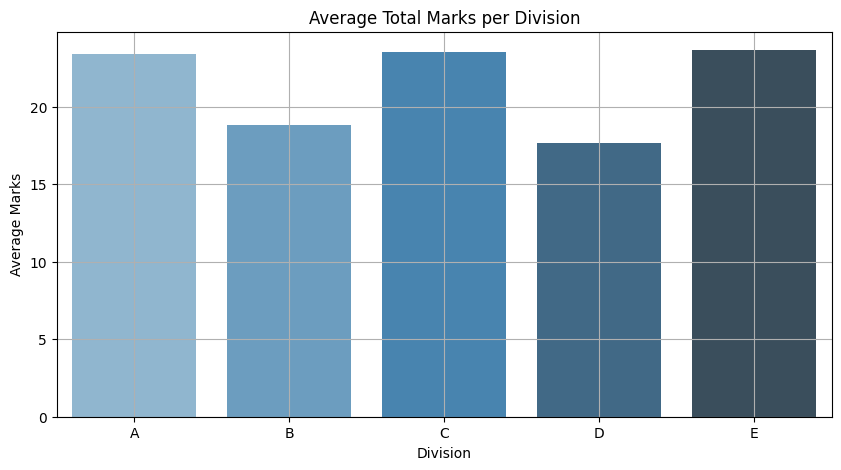

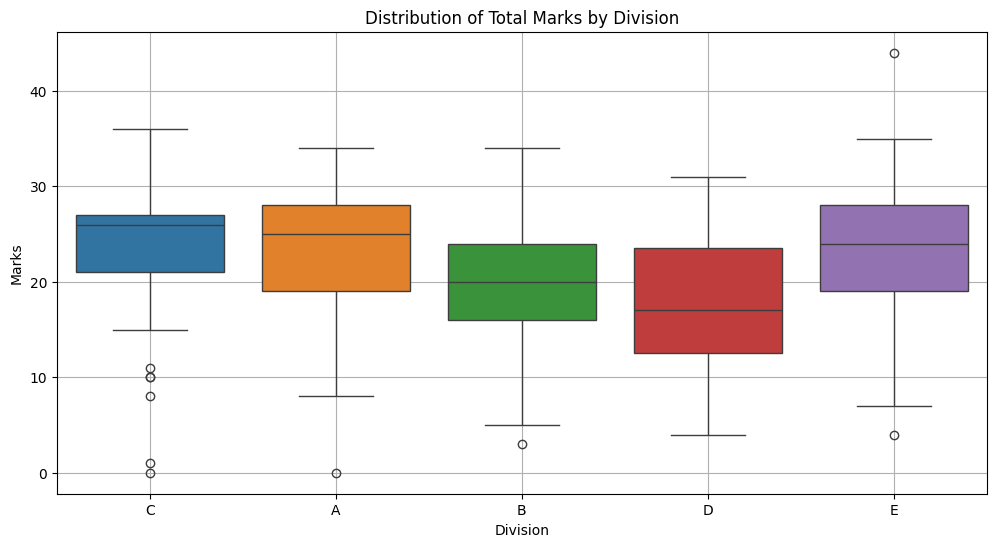

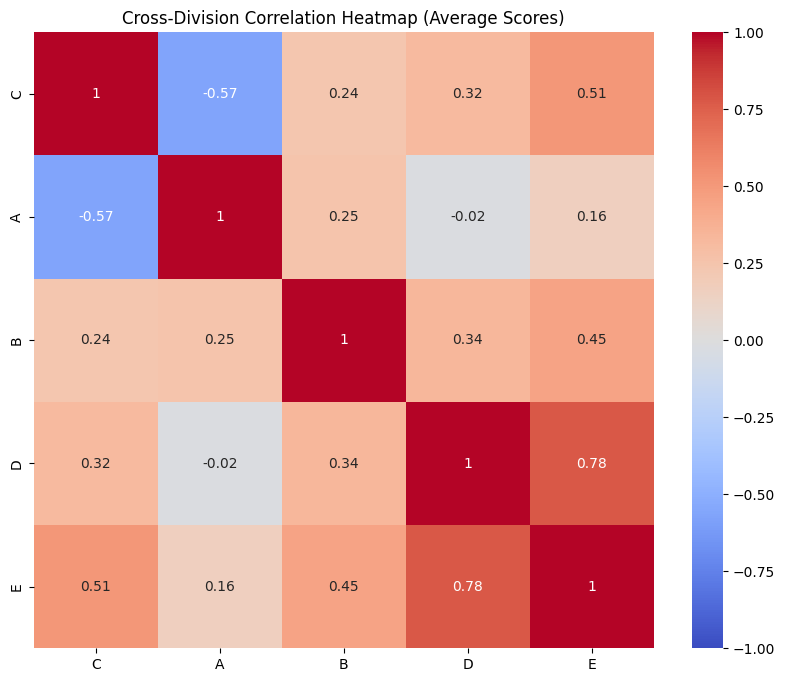

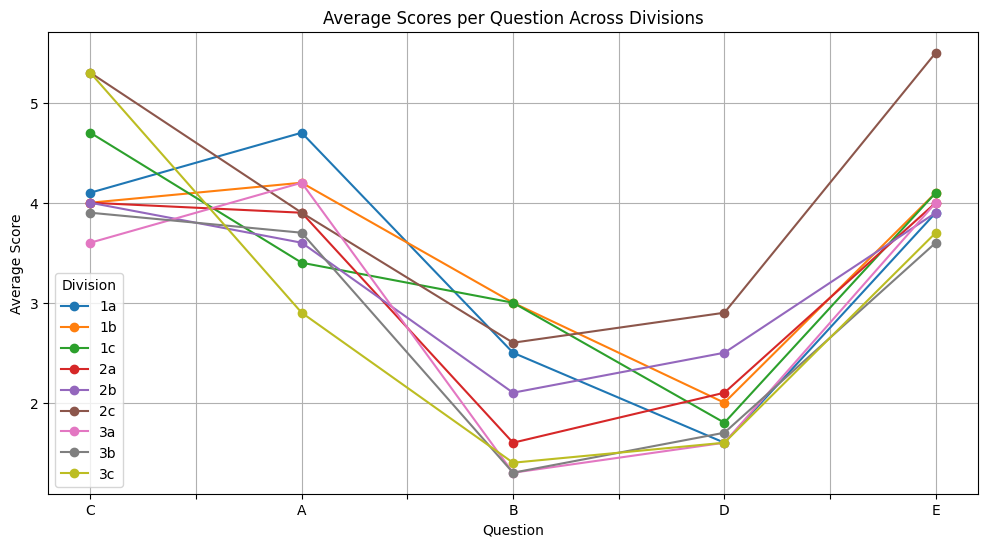

✅ Summary saved as 'ISA_Division_Wise_Summary.xlsx'


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Path to the folder where all CSVs for A, B, C, D, E are saved
folder_path = "/content/drive/MyDrive/ALL_division"

# Data structures to collect stats
division_stats = {}
summary_table = []
hs_ls_by_division = {}
stats_by_division = {}
question_avg_by_division = {}

# Define maximum marks (based on your context)
max_marks = {'1a': 6, '1b': 6, '1c': 8, '2a': 6, '2b': 6, '2c': 8, '3a': 6, '3b': 6, '3c': 8}
summary = pd.DataFrame({'Max Marks': max_marks}, index=max_marks.keys())
question_labels = list(max_marks.keys())

# Read and process each division's marks file
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        division = filename.split("_")[0].upper()  # Extract division name (e.g., A from A_M1.csv)
        file_path = os.path.join(folder_path, filename)

        # Load data and verify initial row count
        df = pd.read_csv(file_path)
        print(f"Initial row count for Division {division}: {len(df)}")

        # Drop duplicates based on Roll.No and USN
        df = df.drop_duplicates(subset=["Roll.No", "USN"])
        print(f"Row count after dropping duplicates for Division {division}: {len(df)}")

        # Drop non-question columns
        non_question_cols = ["SL.No", "Roll.No", "USN", "Name"]
        question_cols = [col for col in df.columns if col in question_labels]
        df_marks = df[question_cols].copy()

        # Clean data and filter out rows with all NA in question columns
        df_marks = df_marks.replace("-", pd.NA).apply(pd.to_numeric, errors='coerce')
        df_marks = df_marks.dropna(how='all')  # Remove rows where all question columns are NA
        print(f"Row count after cleaning and filtering for Division {division}: {len(df_marks)}")

        # Calculate total marks per student
        total_per_student = df_marks.sum(axis=1)

        # Verify student count after processing
        student_count = len(total_per_student)
        print(f"Final student count for Division {division}: {student_count}")

        # Collect overall stats
        division_stats[division] = total_per_student
        summary_table.append({
            "Division": division,
            "Average": round(total_per_student.mean(), 2),
            "Standard Deviation": round(total_per_student.std(), 2),
            "Max Score": round(total_per_student.max(), 2),
            "Min Score": round(total_per_student.min(), 2),
            "Count": student_count
        })

        # Per-Question Analysis: % HS, % LS, Min, Max, Avg, Std Dev
        high_scores = {}
        low_scores = {}
        hs_ls_diff = {}
        stats = {}

        for q in question_cols:
            max_mark = summary.loc[q, 'Max Marks']
            q_scores = df_marks[q].dropna()

            # High vs Low Scores
            hs = q_scores.max() if not q_scores.empty else 0
            ls = q_scores[q_scores > 0].min() if not q_scores[q_scores > 0].empty else 0
            hs_pct = (hs / max_mark) * 100 if max_mark > 0 else 0
            ls_pct = (ls / max_mark) * 100 if max_mark > 0 else 0
            diff = hs_pct - ls_pct

            high_scores[q] = round(hs_pct, 1)
            low_scores[q] = round(ls_pct, 1)
            hs_ls_diff[q] = round(diff, 1)

            # Statistical Metrics
            stats[q] = {
                'Min': q_scores.min() if not q_scores.empty else 0,
                'Max': q_scores.max() if not q_scores.empty else 0,
                'Avg': q_scores.mean() if not q_scores.empty else 0,
                'Std Dev': q_scores.std() if not q_scores.empty and len(q_scores) > 1 else 0
            }

        hs_ls_by_division[division] = pd.DataFrame({
            "% HS": high_scores,
            "% LS": low_scores,
            "%Difference (HS - LS)": hs_ls_diff
        }).round(1)

        stats_by_division[division] = pd.DataFrame(stats).T.round(1)

        # Collect per-question averages for cross-division correlation
        question_avg_by_division[division] = df_marks.mean().round(1)

# --- Summary Table ---
summary_df = pd.DataFrame(summary_table).sort_values("Division")
print("\nSummary Table (Overall Stats):")
display(summary_df)

# --- Per-Division High vs Low and Stats ---
for div in sorted(hs_ls_by_division.keys()):
    print(f"\nHigh vs Low Scorer Table for Division {div}")
    display(hs_ls_by_division[div])
    print(f"\nStatistical Metrics for Division {div}")
    display(stats_by_division[div])

# --- Cross-Division Correlation ---
combined_avg_data = pd.DataFrame(question_avg_by_division)
correlation_across_divisions = combined_avg_data.corr().round(2)
print("\nCross-Division Correlation Matrix (Average Scores):")
display(correlation_across_divisions)

# --- Plot: Average Total Marks per Division ---
plt.figure(figsize=(10, 5))
sns.barplot(x="Division", y="Average", hue="Division", data=summary_df, palette="Blues_d", legend=False)
plt.title("Average Total Marks per Division")
plt.ylabel("Average Marks")
plt.xlabel("Division")
plt.grid(True)
plt.show()

# --- Plot: Box Plot of Marks Distribution ---
all_data = pd.DataFrame(division_stats)
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data)
plt.title("Distribution of Total Marks by Division")
plt.ylabel("Marks")
plt.xlabel("Division")
plt.grid(True)
plt.show()

# --- Plot: Heatmap for Cross-Division Correlation ---
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_across_divisions, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Cross-Division Correlation Heatmap (Average Scores)")
plt.show()

# --- Plot: Per-Question Average Scores Across Divisions ---
combined_avg_data.T.plot(figsize=(12, 6), marker='o')
plt.title("Average Scores per Question Across Divisions")
plt.ylabel("Average Score")
plt.xlabel("Question")
plt.legend(title="Division")
plt.grid(True)
plt.show()

# --- Optional: Save summary table to Excel ---
summary_df.to_excel("ISA_Division_Wise_Summary.xlsx", index=False)
print("✅ Summary saved as 'ISA_Division_Wise_Summary.xlsx'")